In [54]:
%%time
import pandas as pd
import pandas_datareader.data as pdr
import schedule
import wrds 
import yfinance as yf
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as sco
import time
from datetime import datetime, timedelta
import requests_cache
# import seaborn as sns
# import statsmodels.formula.api as smf
# import concurrent.futures
import helper
import matplotlib.dates as mdates

CPU times: user 58 µs, sys: 209 µs, total: 267 µs
Wall time: 286 µs


In [55]:
%%time
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format
session = requests_cache.CachedSession()
from schedule import repeat, every

CPU times: user 4.96 ms, sys: 6.5 ms, total: 11.5 ms
Wall time: 14.2 ms


In [5]:
# conn = wrds.Connection()

In [6]:
# # Fetch the S&P 500 tickers and store them in a DataFrame
# sp500_data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
# sp500_tickers = sp500_data[['Symbol']].copy()
# sp500_tickers.columns = ['Ticker']

# # Display the DataFrame
# print(sp500_tickers)

In [ ]:
%%time
##FINAL DATA DOWNLOAD WITH EXECUTION TIME
def retrieve_stock_data(tickers, start_date, end_date, output_file):
    
    stocks = (yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)
              .assign(Date=lambda x: pd.DatetimeIndex(x.index).tz_localize(None))
              .set_index('Date')
              .rename_axis(columns=['Variable', 'Ticker']))
    ff_data = pdr.DataReader(name='F-F_Research_Data_Factors_daily', data_source='famafrench', start=start_date)[0]
    stocks.to_csv(output_file, index=True)
    ff_data.to_csv('ff.csv', index=True)
def run_job(start_date, end_date, output_file):
    
    #ckers = sp500_tickers['Symbol'].tolist()
    tickers = 'SPYG FNDF QYLD AMAX QUBT F UBS CRED GOLD NVDA'
    retrieve_stock_data(tickers, start_date, end_date, output_file)
    print("Stock data downloaded and saved.")

# Calculate start_date and end_date outside the run_job() function
start_date = (datetime.now() - timedelta(days=365 * 3)).strftime('%Y-%m-%d') #FOR 3YEAR TO DAT
#start_date = datetime(datetime.now().year, 1, 1).strftime('%Y-%m-%d') #FOR YEAR TO DATE
end_date = datetime.now().strftime('%Y-%m-%d')

output_file = 'stock_data.csv'
ff_output_file = 'ff.csv'
# Schedule the job to run at a specific time during the day
schedule.every().day.at("06:55").do(run_job, start_date=start_date, end_date=end_date, output_file=output_file)

while True:
    schedule.run_pending()
    time.sleep(1)
  

[*********************100%***********************]  10 of 10 completed
Stock data downloaded and saved.


In [116]:
my = (
            pd.read_csv(
filepath_or_buffer='stock_data.csv', header=[0, 1],
index_col=0,
parse_dates=True
)
            .rename_axis(columns=['Variable', 'Ticker'])
        )
my.head()

Variable   Adj Close                                                     \
Ticker          AMAX CRED      F    FNDF    GOLD    NVDA   QUBT    QYLD   
Date                                                                      
2020-06-05       NaN  NaN 6.5711 23.1300 21.2201 88.9709 2.6500 14.4182   
2020-06-08       NaN  NaN 6.7412 23.5600 21.4661 87.8238 3.0200 14.4182   
2020-06-09       NaN  NaN 6.4816 23.1483 22.1677 90.2276 3.1600 14.4321   
2020-06-10       NaN  NaN 6.0967 22.9744 22.8510 93.4269 3.1500 14.4459   
2020-06-11       NaN  NaN 5.4879 21.5288 22.1495 87.7365 2.8500 14.3351   

Variable                    ... Volume                                     \
Ticker        SPYG     UBS  ...   AMAX CRED          F     FNDF      GOLD   
Date                        ...                                             
2020-06-05 43.6368 10.5286  ...    NaN  NaN  208648200   841300  28169100   
2020-06-08 43.9481 10.7904  ...    NaN  NaN  113169300  1442500  15541600   
2020-06-09 43.9871 10.5737  ...    NaN  NaN  115749600   775700  21508000   
2020-06-10 44.2206 10.3751  ...    NaN  NaN  147327100   615700  21908200   
2020-06-11 41.8855  9.6527  ...    NaN  NaN  116184700  1649900  30986200   

Variable                                                
Ticker          NVDA   QUBT    QYLD      SPYG      UBS  
Date                                                    
2020-06-05  48174800  91300  639400   1773500  4241400  
2020-06-08  38773600  61800  777900   3268100  3772000  
2020-06-09  46848800  78200  498600  19029900  3513000  
2020-06-10  63218000  61200  854200   2864100  4377600  
2020-06-11  58365200  42800  898300   3475000  3935600  

[5 rows x 60 columns]

In [117]:
returns = my['Adj Close'].pct_change()
returns

Ticker,AMAX,CRED,F,FNDF,GOLD,NVDA,QUBT,QYLD,SPYG,UBS
Date,,,,,,,,,,
2020-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-08,NaN,NaN,0.0259,0.0186,0.0116,-0.0129,0.1396,0.0000,0.0071,0.0249
2020-06-09,NaN,NaN,-0.0385,-0.0175,0.0327,0.0274,0.0464,0.0010,0.0009,-0.0201
2020-06-10,NaN,NaN,-0.0594,-0.0075,0.0308,0.0355,-0.0032,0.0010,0.0053,-0.0188
2020-06-11,NaN,NaN,-0.0999,-0.0629,-0.0307,-0.0609,-0.0952,-0.0077,-0.0528,-0.0696
...,...,...,...,...,...,...,...,...,...,...
2023-05-26,0.0036,0.0127,0.0624,0.0077,-0.0059,0.0254,0.0169,0.0074,0.0126,0.0128
2023-05-30,0.0006,0.0035,0.0414,-0.0073,-0.0065,0.0299,0.0250,0.0017,0.0009,-0.0191
2023-05-31,0.0019,0.0058,-0.0469,-0.0137,0.0060,-0.0568,-0.0488,0.0006,-0.0057,-0.0288


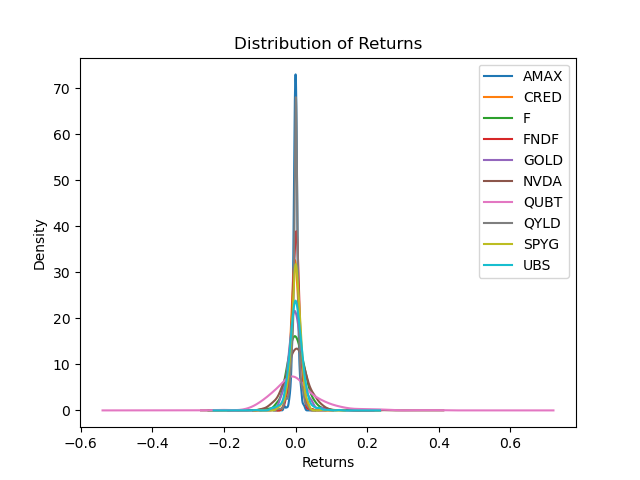

In [249]:
plt.hist(returns, bins=30, density=True, alpha=0.5, label='Portfolio 1')


# Plot kernel density estimate
returns.plot.kde(label='Portfolio')


# Set plot labels and title
plt.xlabel('Returns')
plt.ylabel('Density')
plt.title('Distribution of Returns')
plt.legend()

# Show the plot
plt.show()

In [250]:
Dollar_volume = my['Adj Close']*my['Volume']
Dollar_volume

Ticker,AMAX,CRED,F,FNDF,GOLD,NVDA,QUBT,QYLD,SPYG,UBS
Date,,,,,,,,,,
2020-06-05,NaN,NaN,1371056692.8025,19459252.2474,597751345.1706,4286153547.3419,241945.0087,9219021.1765,77389869.5412,44655917.9901
2020-06-08,NaN,NaN,762901144.8956,33985307.4837,333617639.4562,3405246337.1704,186635.9988,11215947.0961,143626913.6890,40701534.5955
2020-06-09,NaN,NaN,750244351.3046,17956118.6882,476782354.2938,4227056221.1670,247112.0067,7195836.6486,837069508.6876,37145508.4362
2020-06-10,NaN,NaN,898202836.1896,14145360.1259,500624734.1751,5906260974.7467,192780.0058,12339718.7046,126652144.3474,45417929.8096
2020-06-11,NaN,NaN,637608549.1704,35520387.5927,686327415.1546,5120761251.7242,121979.9959,12877247.9002,145552105.7129,37989179.0493
...,...,...,...,...,...,...,...,...,...,...
2023-05-26,42707.4993,1924.0999,1490183193.8076,38351235.6293,187117547.2382,27822904951.5533,2258280.0897,101034562.1899,75850207.6000,26771695.5145
2023-05-30,413363.9990,1930.9000,1085596684.1572,28500596.1388,188610563.7180,37038536158.3618,2021259.0313,76385497.3639,96801692.9398,44268937.4388
2023-05-31,60722.9988,1942.1000,1035303600.0000,34158640.8314,241910643.9728,37931611352.8442,845792.9690,49658362.2818,71641960.1898,63098887.4908


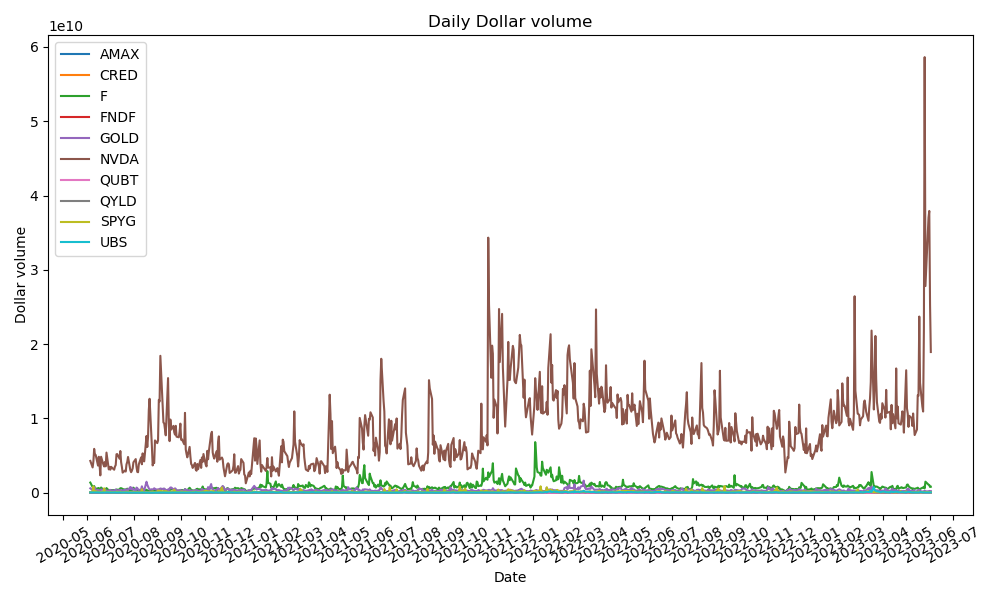

In [251]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
ax.plot(Dollar_volume)
ax.set_xlabel('Date')
ax.set_ylabel('Dollar volume', labelpad=0.5)
ax.set_title('Daily Dollar volume')

# Set the x-axis tick labels to be more frequent with a monthly interval
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.tick_params(axis='x', rotation=30)

ax.legend(returns_columns)
plt.show()

In [252]:
returns.describe()

Ticker,AMAX,CRED,F,FNDF,GOLD,NVDA,QUBT,QYLD,SPYG,UBS
count,388.0000,22.0000,753.0000,753.0000,753.0000,753.0000,753.0000,753.0000,753.0000,753.0000
mean,-0.0002,-0.0004,0.0012,0.0005,-0.0000,0.0025,0.0014,0.0003,0.0005,0.0011
std,0.0069,0.0118,0.0273,0.0115,0.0220,0.0339,0.0713,0.0102,0.0144,0.0205
min,-0.0318,-0.0245,-0.1232,-0.0629,-0.0865,-0.0947,-0.2243,-0.0525,-0.0528,-0.1126
25%,-0.0035,-0.0058,-0.0154,-0.0065,-0.0128,-0.0158,-0.0405,-0.0026,-0.0073,-0.0103
50%,-0.0001,-0.0015,0.0000,0.0009,-0.0015,0.0032,-0.0070,0.0009,0.0009,0.0006
75%,0.0032,0.0068,0.0176,0.0074,0.0111,0.0217,0.0293,0.0041,0.0095,0.0125
max,0.0255,0.0251,0.1167,0.0486,0.1163,0.2437,0.4056,0.0382,0.0739,0.1197


In [253]:
ff = pd.read_csv('ff.csv', index_col='Date', parse_dates=True)

In [254]:
ff.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2020-06-05,2.5000,0.6700,2.7700,0.0000
2020-06-08,1.3900,0.3700,2.0900,0.0000
2020-06-09,-0.8500,-0.2500,-1.9300,0.0000
2020-06-10,-0.5600,-0.8600,-4.1000,0.0000
2020-06-11,-5.9100,-0.8200,-3.0400,0.0000


In [255]:
returns_columns = ['AMAX', 'CRED', 'F', 'FNDF', 'GOLD', 'NVDA', 'QUBT', 'QYLD', 'SPYG', 'UBS']  # List of return column names
rolling_window = 252  # Rolling window size

rhos = returns[returns_columns].rolling(rolling_window).corr()

In [256]:
rhos

Ticker              AMAX  CRED      F   FNDF   GOLD   NVDA   QUBT   QYLD  \
Date       Ticker                                                          
2020-06-05 AMAX      NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           CRED      NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           F         NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           FNDF      NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   
           GOLD      NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...                  ...   ...    ...    ...    ...    ...    ...    ...   
2023-06-02 NVDA   0.5190   NaN 0.5354 0.5684 0.2136 1.0000 0.2866 0.6844   
           QUBT   0.2632   NaN 0.2750 0.3279 0.0440 0.2866 1.0000 0.3189   
           QYLD   0.7999   NaN 0.5780 0.7034 0.3326 0.6844 0.3189 1.0000   
           SPYG   0.7090   NaN 0.6762 0.7685 0.3413 0.7517 0.3366 0.8728   
           UBS    0.4660   NaN 0.5593 0.7498 0.1783 0.4394 0.3369 0.5072   

Ticker              SPYG    UBS  
Date       Ticker                
2020-06-05 AMAX      NaN    NaN  
           CRED      NaN    NaN  
           F         NaN    NaN  
           FNDF      NaN    NaN  
           GOLD      NaN    NaN  
...                  ...    ...  
2023-06-02 NVDA   0.7517 0.4394  
           QUBT   0.3366 0.3369  
           QYLD   0.8728 0.5072  
           SPYG   1.0000 0.6080  
           UBS    0.6080 1.0000  

[7540 rows x 10 columns]

In [257]:
returns_msd = returns.groupby(pd.Grouper(freq='M'))#.agg(['mean', 'std'])
returns_msd.head()


Ticker,AMAX,CRED,F,FNDF,GOLD,NVDA,QUBT,QYLD,SPYG,UBS
Date,,,,,,,,,,
2020-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-08,NaN,NaN,0.0259,0.0186,0.0116,-0.0129,0.1396,0.0000,0.0071,0.0249
2020-06-09,NaN,NaN,-0.0385,-0.0175,0.0327,0.0274,0.0464,0.0010,0.0009,-0.0201
2020-06-10,NaN,NaN,-0.0594,-0.0075,0.0308,0.0355,-0.0032,0.0010,0.0053,-0.0188
2020-06-11,NaN,NaN,-0.0999,-0.0629,-0.0307,-0.0609,-0.0952,-0.0077,-0.0528,-0.0696
...,...,...,...,...,...,...,...,...,...,...
2023-05-03,-0.0035,0.0000,-0.0008,0.0003,0.0096,-0.0145,-0.0179,-0.0012,-0.0058,-0.0281
2023-05-04,-0.0017,-0.0118,-0.0195,-0.0038,0.0225,-0.0086,-0.0273,-0.0023,-0.0067,-0.0202
2023-05-05,0.0058,0.0173,0.0372,0.0199,-0.0113,0.0406,0.0374,0.0110,0.0210,0.0401


In [258]:
returns_msd.describe()

Ticker        AMAX                                                        \
             count    mean    std     min     25%     50%     75%    max   
Date                                                                       
2020-06-30  0.0000     NaN    NaN     NaN     NaN     NaN     NaN    NaN   
2020-07-31  0.0000     NaN    NaN     NaN     NaN     NaN     NaN    NaN   
2020-08-31  0.0000     NaN    NaN     NaN     NaN     NaN     NaN    NaN   
2020-09-30  0.0000     NaN    NaN     NaN     NaN     NaN     NaN    NaN   
2020-10-31  0.0000     NaN    NaN     NaN     NaN     NaN     NaN    NaN   
2020-11-30  0.0000     NaN    NaN     NaN     NaN     NaN     NaN    NaN   
2020-12-31  0.0000     NaN    NaN     NaN     NaN     NaN     NaN    NaN   
2021-01-31  0.0000     NaN    NaN     NaN     NaN     NaN     NaN    NaN   
2021-02-28  0.0000     NaN    NaN     NaN     NaN     NaN     NaN    NaN   
2021-03-31  0.0000     NaN    NaN     NaN     NaN     NaN     NaN    NaN   
2021-04-30  0.0000     NaN    NaN     NaN     NaN     NaN     NaN    NaN   
2021-05-31  0.0000     NaN    NaN     NaN     NaN     NaN     NaN    NaN   
2021-06-30  0.0000     NaN    NaN     NaN     NaN     NaN     NaN    NaN   
2021-07-31  0.0000     NaN    NaN     NaN     NaN     NaN     NaN    NaN   
2021-08-31  0.0000     NaN    NaN     NaN     NaN     NaN     NaN    NaN   
2021-09-30  0.0000     NaN    NaN     NaN     NaN     NaN     NaN    NaN   
2021-10-31  0.0000     NaN    NaN     NaN     NaN     NaN     NaN    NaN   
2021-11-30 10.0000 -0.0027 0.0056 -0.0118 -0.0070 -0.0018 -0.0005 0.0066   
2021-12-31 22.0000  0.0012 0.0059 -0.0077 -0.0044  0.0024  0.0062 0.0103   
2022-01-31 20.0000 -0.0019 0.0049 -0.0103 -0.0048 -0.0018 -0.0003 0.0089   
2022-02-28 19.0000  0.0005 0.0035 -0.0044 -0.0027  0.0000  0.0030 0.0083   
2022-03-31 23.0000  0.0003 0.0060 -0.0127 -0.0023  0.0011  0.0042 0.0097   
2022-04-30 20.0000 -0.0019 0.0103 -0.0308 -0.0060 -0.0024  0.0012 0.0255   
2022-05-31 21.0000 -0.0007 0.0103 -0.0260 -0.0073  0.0003  0.0044 0.0168   
2022-06-30 21.0000 -0.0009 0.0074 -0.0219 -0.0022 -0.0016  0.0026 0.0143   
2022-07-31 20.0000  0.0012 0.0060 -0.0090 -0.0023  0.0018  0.0047 0.0151   
2022-08-31 23.0000 -0.0019 0.0047 -0.0147 -0.0031 -0.0006  0.0009 0.0049   
2022-09-30 21.0000 -0.0023 0.0109 -0.0318 -0.0060 -0.0031  0.0019 0.0170   
2022-10-31 21.0000  0.0016 0.0110 -0.0177 -0.0042  0.0009  0.0091 0.0229   
2022-11-30 21.0000  0.0010 0.0069 -0.0083 -0.0026  0.0000  0.0026 0.0196   
2022-12-31 21.0000 -0.0008 0.0066 -0.0143 -0.0071  0.0013  0.0039 0.0093   
2023-01-31 20.0000  0.0024 0.0045 -0.0034 -0.0007  0.0016  0.0037 0.0157   
2023-02-28 19.0000 -0.0012 0.0053 -0.0121 -0.0050  0.0000  0.0032 0.0091   
2023-03-31 23.0000  0.0002 0.0060 -0.0109 -0.0033  0.0005  0.0023 0.0149   
2023-04-30 19.0000  0.0006 0.0026 -0.0026 -0.0012  0.0006  0.0013 0.0092   
2023-05-31 22.0000  0.0000 0.0028 -0.0045 -0.0024  0.0003  0.0019 0.0058   
2023-06-30  2.0000  0.0032 0.0009  0.0026  0.0029  0.0032  0.0035 0.0039   

Ticker        CRED          ...   SPYG            UBS                         \
             count    mean  ...    75%    max   count    mean    std     min   
Date                        ...                                                
2020-06-30  0.0000     NaN  ... 0.0105 0.0207 17.0000 -0.0003 0.0264 -0.0696   
2020-07-31  0.0000     NaN  ... 0.0114 0.0204 22.0000  0.0007 0.0160 -0.0200   
2020-08-31  0.0000     NaN  ... 0.0083 0.0189 21.0000  0.0019 0.0106 -0.0170   
2020-09-30  0.0000     NaN  ... 0.0129 0.0260 21.0000 -0.0038 0.0230 -0.0549   
2020-10-31  0.0000     NaN  ... 0.0085 0.0220 22.0000  0.0023 0.0186 -0.0414   
2020-11-30  0.0000     NaN  ... 0.0107 0.0349 20.0000  0.0111 0.0238 -0.0282   
2020-12-31  0.0000     NaN  ... 0.0052 0.0131 22.0000  0.0000 0.0130 -0.0194   
2021-01-31  0.0000     NaN  ... 0.0071 0.0232 19.0000  0.0012 0.0227 -0.0477   
2021-02-28  0.0000     NaN  ... 0.0051 0.0218 19.0000  0.0041 0.0144 -0.0177   

In [259]:
returns_m = (
returns
.resample(rule='M', kind='period') .apply(lambda x: (1 + x).prod() - 1)
)
returns_m.head()

Ticker,AMAX,CRED,F,FNDF,GOLD,NVDA,QUBT,QYLD,SPYG,UBS
Date,,,,,,,,,,
2020-06,0.0000,0.0000,-0.1717,-0.0533,0.1567,0.0648,0.0113,0.0188,0.0043,-0.0103
2020-07,0.0000,0.0000,0.0872,0.0084,0.0731,0.1176,-0.1604,0.0380,0.0706,0.0121
2020-08,0.0000,0.0000,0.0318,0.0564,0.0285,0.2600,0.8178,0.0363,0.0944,0.0402
2020-09,0.0000,0.0000,-0.0235,-0.0285,-0.0519,0.0120,-0.0978,-0.0164,-0.0458,-0.0823
2020-10,0.0000,0.0000,0.1607,-0.0281,-0.0491,-0.0736,-0.0745,-0.0307,-0.0303,0.0484


In [260]:
returns_m.describe()

Ticker,AMAX,CRED,F,FNDF,GOLD,NVDA,QUBT,QYLD,SPYG,UBS
count,37.0000,37.0000,37.0000,37.0000,37.0000,37.0000,37.0000,37.0000,37.0000,37.0000
mean,-0.0022,-0.0003,0.0258,0.0103,-0.0009,0.0535,0.0295,0.0064,0.0099,0.0204
std,0.0202,0.0065,0.1327,0.0560,0.0966,0.1619,0.3906,0.0412,0.0601,0.0798
min,-0.0492,-0.0323,-0.2651,-0.0979,-0.1703,-0.3203,-0.4115,-0.0728,-0.1263,-0.1404
25%,0.0000,0.0000,-0.0503,-0.0252,-0.0729,-0.0264,-0.1766,-0.0212,-0.0303,-0.0262
50%,0.0000,0.0000,0.0318,0.0084,0.0079,0.0558,-0.0903,0.0114,0.0229,0.0121
75%,0.0050,0.0000,0.1111,0.0384,0.0605,0.1883,0.0186,0.0363,0.0500,0.0706
max,0.0490,0.0218,0.3199,0.1780,0.1838,0.3634,1.6523,0.1004,0.1276,0.2408


In [261]:
returns_columns = ['AMAX', 'CRED', 'F', 'FNDF', 'GOLD', 'NVDA', 'QUBT', 'QYLD', 'SPYG', 'UBS']  # List of return column names
rolling_window = 21
rhos_m = (
             returns_m[returns_columns].rolling(rolling_window).corr()
)

In [262]:
rhos_m

Ticker           AMAX    CRED      F   FNDF    GOLD   NVDA   QUBT   QYLD  \
Date    Ticker                                                             
2020-06 AMAX      NaN     NaN    NaN    NaN     NaN    NaN    NaN    NaN   
        CRED      NaN     NaN    NaN    NaN     NaN    NaN    NaN    NaN   
        F         NaN     NaN    NaN    NaN     NaN    NaN    NaN    NaN   
        FNDF      NaN     NaN    NaN    NaN     NaN    NaN    NaN    NaN   
        GOLD      NaN     NaN    NaN    NaN     NaN    NaN    NaN    NaN   
...               ...     ...    ...    ...     ...    ...    ...    ...   
2023-06 NVDA   0.5933 -0.2987 0.6468 0.4566  0.1827 1.0000 0.4139 0.7869   
        QUBT   0.3085 -0.0107 0.3418 0.2704 -0.0588 0.4139 1.0000 0.2651   
        QYLD   0.8496 -0.1024 0.6886 0.5979  0.2875 0.7869 0.2651 1.0000   
        SPYG   0.7645 -0.0289 0.8474 0.6495  0.1738 0.8145 0.4477 0.8994   
        UBS    0.5505  0.2371 0.5352 0.8598  0.3281 0.4744 0.3554 0.4536   

Ticker           SPYG    UBS  
Date    Ticker                
2020-06 AMAX      NaN    NaN  
        CRED      NaN    NaN  
        F         NaN    NaN  
        FNDF      NaN    NaN  
        GOLD      NaN    NaN  
...               ...    ...  
2023-06 NVDA   0.8145 0.4744  
        QUBT   0.4477 0.3554  
        QYLD   0.8994 0.4536  
        SPYG   1.0000 0.5698  
        UBS    0.5698 1.0000  

[370 rows x 10 columns]

In [263]:
excess_returns = returns.drop('SPYG', axis=1).sub(returns['SPYG'], axis=0)
excess_returns

Ticker,AMAX,CRED,F,FNDF,GOLD,NVDA,QUBT,QYLD,UBS
Date,,,,,,,,,
2020-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-08,NaN,NaN,0.0188,0.0115,0.0045,-0.0200,0.1325,-0.0071,0.0177
2020-06-09,NaN,NaN,-0.0394,-0.0184,0.0318,0.0265,0.0455,0.0001,-0.0210
2020-06-10,NaN,NaN,-0.0647,-0.0128,0.0255,0.0301,-0.0085,-0.0043,-0.0241
2020-06-11,NaN,NaN,-0.0470,-0.0101,0.0221,-0.0081,-0.0424,0.0451,-0.0168
...,...,...,...,...,...,...,...,...,...
2023-05-26,-0.0090,0.0001,0.0498,-0.0049,-0.0184,0.0128,0.0044,-0.0052,0.0002
2023-05-30,-0.0002,0.0027,0.0405,-0.0081,-0.0074,0.0290,0.0241,0.0008,-0.0200
2023-05-31,0.0076,0.0115,-0.0412,-0.0080,0.0117,-0.0511,-0.0431,0.0063,-0.0231


In [264]:
avg_excess_return = excess_returns.mean()
avg_excess_return

Ticker
AMAX    0.0001
CRED   -0.0031
F       0.0007
FNDF   -0.0000
GOLD   -0.0005
NVDA    0.0020
QUBT    0.0009
QYLD   -0.0002
UBS     0.0006
dtype: float64

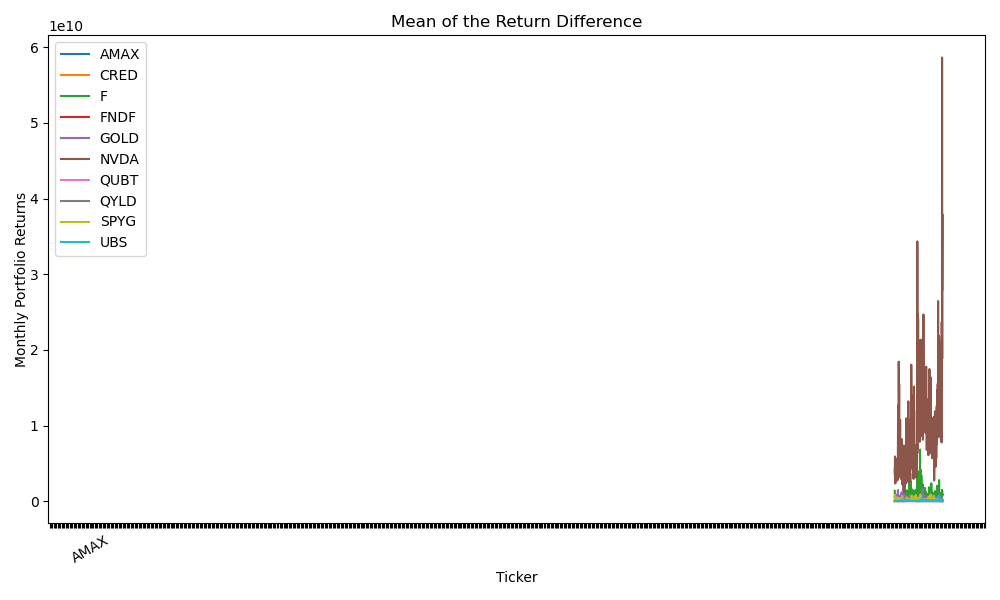

In [265]:
avg_excess_return.plot(kind="line")
plt.ylabel('Monthly Portfolio Returns')
plt.title('Mean of the Return Difference')
plt.xticks(rotation=30)
plt.legend(returns_columns)
plt.show()

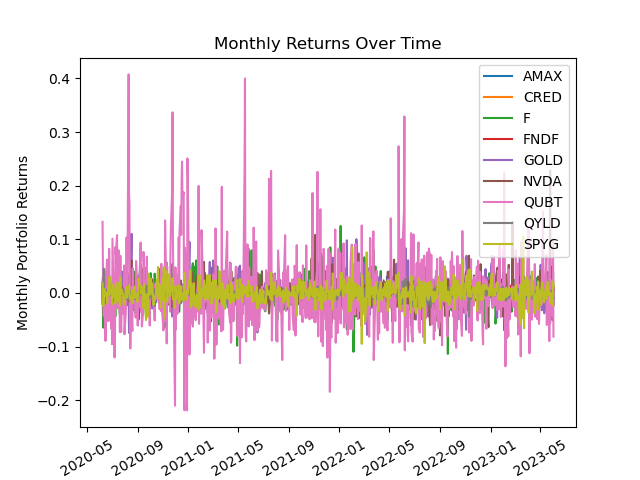

In [266]:
%matplotlib widget
plt.plot(excess_returns)
plt.xlabel('Date')
plt.ylabel('Monthly Portfolio Returns')
plt.title('Monthly Returns Over Time')
plt.xticks(rotation=30)
plt.legend(returns_columns)
plt.show()

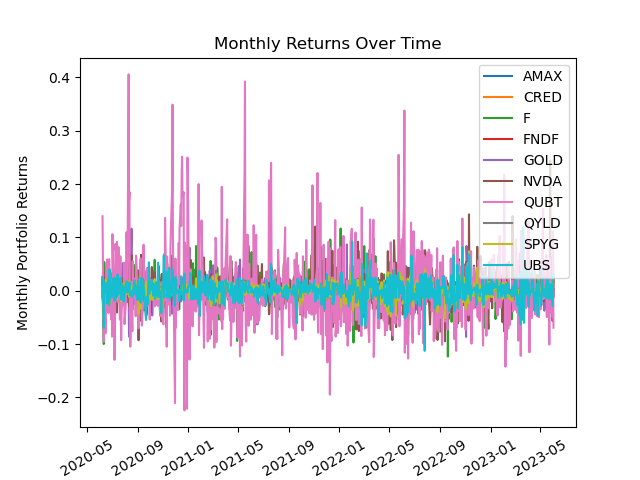

In [267]:
%matplotlib widget
plt.plot(returns)
plt.xlabel('Date')
plt.ylabel('Monthly Portfolio Returns')
plt.title('Monthly Returns Over Time')
plt.xticks(rotation=30)
plt.legend(returns_columns)
plt.show()

In [268]:
weights = np.array([0.1, 0.2, 0.15, 0.25, 0.05, 0.1, 0.05, 0.02, 0.08, 0.1])
returns_p = returns.dot(weights)
totret = returns_p.add(1).prod() - 1
totret

0.0514

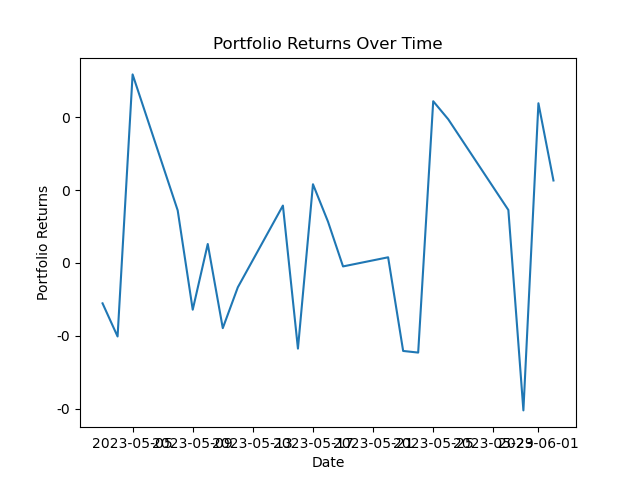

In [269]:
%matplotlib widget
plt.plot(returns_p)
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Date')
plt.ylabel('Portfolio Returns')
plt.title('Portfolio Returns Over Time')
plt.show()

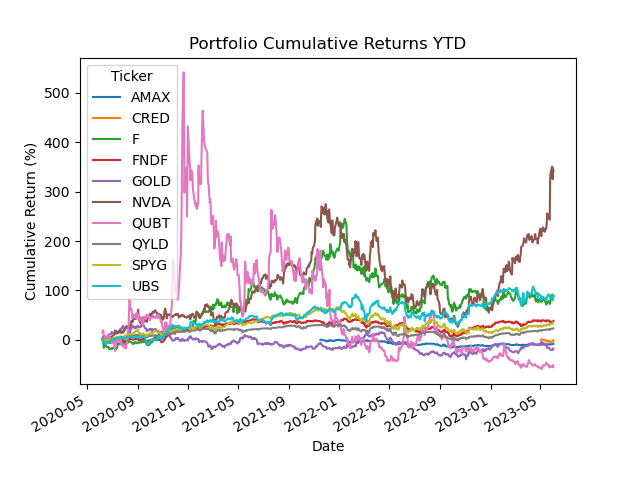

In [270]:
#cumulative returns as percents
%matplotlib widget
returns_cr = returns.add(1).cumprod().sub(1).mul(100).plot()
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylabel('Cumulative Return (%)')
plt.title('Portfolio Cumulative Returns YTD')
plt.show()

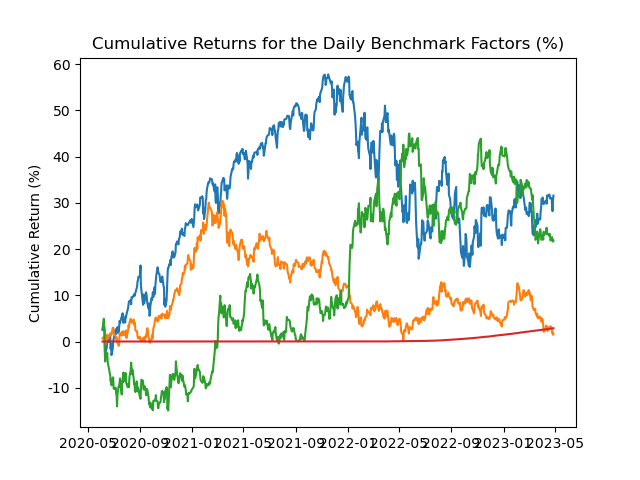

In [271]:
%matplotlib widget

# Apply the desired methodology to ff
y = (
    ff
    .div(100)
    .add(1)
    .cumprod()
    .sub(1)
    .mul(100)
)

# Plot the modified data
plt.plot(y)

# Set the y-axis label and title
plt.ylabel('Cumulative Return (%)')
plt.title('Cumulative Returns for the Daily Benchmark Factors (%)')

# Format the y-axis tick labels
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

# Display the plot
plt.show()

In [272]:
def sharpe(ri, rf=ff['RF'], ann_fac=np.sqrt(252)):
    ri_rf = ri.sub(rf).dropna()
    return ann_fac * ri_rf.mean() / ri_rf.std()

In [273]:
sharpe

<function __main__.sharpe(ri, rf=Date
2020-06-05   0.0000
2020-06-08   0.0000
2020-06-09   0.0000
2020-06-10   0.0000
2020-06-11   0.0000
              ...  
2023-04-24   0.0180
2023-04-25   0.0180
2023-04-26   0.0180
2023-04-27   0.0180
2023-04-28   0.0180
Name: RF, Length: 730, dtype: float64, ann_fac=15.874507866387544)>

In [274]:
def beta(ri, rf=ff['RF'], rm_rf=ff['Mkt-RF']):
    ri_rf = ri.sub(rf).dropna()
    return ri_rf.cov(rm_rf) / rm_rf.loc[ri_rf.index].var()

In [275]:
beta

<function __main__.beta(ri, rf=Date
2020-06-05   0.0000
2020-06-08   0.0000
2020-06-09   0.0000
2020-06-10   0.0000
2020-06-11   0.0000
              ...  
2023-04-24   0.0180
2023-04-25   0.0180
2023-04-26   0.0180
2023-04-27   0.0180
2023-04-28   0.0180
Name: RF, Length: 730, dtype: float64, rm_rf=Date
2020-06-05    2.5000
2020-06-08    1.3900
2020-06-09   -0.8500
2020-06-10   -0.5600
2020-06-11   -5.9100
               ...  
2023-04-24    0.0000
2023-04-25   -1.7600
2023-04-26   -0.4100
2023-04-27    1.8500
2023-04-28    0.7700
Name: Mkt-RF, Length: 730, dtype: float64)>

In [276]:
betas = {}  # Use a different variable name to store the betas

for column in returns:
    sharpe = sharpe(returns[column])
    sharpe[column] = sharpe

# Print Sharpe ratios for each stock
for stock, sharpe_ratio in sharpe_ratios.items():
    print(f"Sharpe Ratio for {stock}: {sharpe_ratio}")

TypeError: 'numpy.float64' object does not support item assignment

In [ ]:
betas_series = pd.Series(betas)
betas_series.plot(kind='bar')
plt.ylabel('PORT Beta')
plt.title('PORT Betas')
plt.show()

In [ ]:
%%time
sharpe_ratios = {}
for column in main.columns[60:70]:  # Assuming return columns start from index 7
    sharpe_ratio = sharpe(main[column])
    sharpe_ratios[column] = sharpe_ratio

# Print Sharpe ratios for each stock
for stock, sharpe_ratio in sharpe_ratios.items():
    print(f"Sharpe Ratio for {stock}: {sharpe_ratio}")

In [ ]:
sharpe_series = pd.Series(sharpe_ratios)
betas_series.plot(kind='bar')
plt.ylabel('PORT Sharpe')
plt.title('PORT Sharpe')
plt.show()

In [ ]:
sorted_ratios = sorted(sharpe_ratios.items(), key=lambda x: x[1], reverse=True)
for stock, sharpe_ratio in sorted_ratios:
    print(f"Sharpe Ratio for {stock}: {sharpe_ratio}")

In [277]:
threshold = 1.5
filtered_stocks = {stock: sharpe_ratio for stock, sharpe_ratio in sharpe_ratios.items() if sharpe_ratio > threshold}
for stock, sharpe_ratio in filtered_stocks.items():
    print(f"Sharpe Ratio for {stock}: {sharpe_ratio}")

In [197]:
max_ratio_stock = max(sharpe_ratios, key=sharpe_ratios.get)
max_ratio = sharpe_ratios[max_ratio_stock]
print(f"Stock with the highest Sharpe Ratio: {max_ratio_stock} ({max_ratio})")

ValueError: max() arg is an empty sequence

In [198]:
returns.agg([sharpe, beta])

AssertionError: 

In [199]:
def port_vol(x, r, ppy):
    return np.sqrt(ppy) * r.dot(x).std()
n = returns.shape[1]

res_2 = sco.minimize(
            fun=port_vol,
x0=np.ones(n) / n, args=(returns, 252), bounds=[(0,1) for _ in range(n)], constraints=(
{'type': 'eq', 'fun': lambda x: x.sum()-1} )
        )
weights_2 = res_2['x']
res_2

     fun: 0.04255399274480837
     jac: array([0.0426, 0.0926, 0.2128, 0.0805, 0.0421, 0.3015, 0.0425, 0.0424,
       0.092 , 0.1528])
 message: 'Optimization terminated successfully'
    nfev: 143
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([9.0531e-01, 0.0000e+00, 0.0000e+00, 3.2092e-17, 2.6882e-02,
       0.0000e+00, 5.9093e-03, 6.1896e-02, 0.0000e+00, 0.0000e+00])

In [200]:
n = returns.shape[1]

res_3 = sco.minimize(
    fun=port_vol,
x0=np.ones(n) / n,
args=(returns, 252),
bounds=[(-0.3, 1.3) for _ in range(n)], constraints=(
{'type': 'eq', 'fun': lambda x: x.sum() - 1},
{'type': 'ineq', 'fun': lambda x: 1.3 - x[x > 0].sum()} )
)
weights_3 = res_3['x']
res_3

/Users/omkarchavan/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


     fun: 0.030241929863734366
     jac: array([0.0338, 0.045 , 0.0454, 0.0339, 0.0338, 0.0458, 0.046 , 0.0334,
       0.045 , 0.0403])
 message: 'Optimization terminated successfully'
    nfev: 287
     nit: 25
    njev: 25
  status: 0
 success: True
       x: array([ 7.0098e-01, -3.8562e-02, -1.9976e-02,  5.5713e-02,  6.4497e-03,
       -1.5750e-02, -2.0577e-05,  5.3686e-01, -2.2569e-01,  8.9614e-08])

In [201]:
def sr(rp, ppy):
    return np.sqrt(ppy) * rp.mean() / rp.std()

def sr_neg(x, r, ppy):
    rp = r.dot(x)
    return -1 * sr(rp=rp, ppy=ppy)

n = returns.shape[1]
res = sco.minimize(fun=sr_neg,
                   x0=np.ones(n) / n,
                   args=(returns, 252),
                   bounds=[(0, 0.3) for c in returns],
                   constraints=[{'type':'eq', 'fun':lambda x: x.sum() - 1}]
)

assert res['success']
weights = res['x']
portfolio = returns.dot(weights)
sr_rolling = portfolio.rolling(window=252, min_periods=200).apply(lambda x: sr(rp=x, ppy=252))

In [202]:
rp = returns.dot(weights)
ppy = 252

# Call sr function
sharpe_ratio = sr(rp, ppy)
print("Sharpe Ratio:", sharpe_ratio)

# Call sr_neg function
negative_sharpe_ratio = sr_neg(weights, returns, ppy)
print("Negative Sharpe Ratio:", negative_sharpe_ratio)

Sharpe Ratio: 5.614872395634322
Negative Sharpe Ratio: -5.614872395634322


In [203]:
rp_1 = returns.mean(axis=1)
rp_1.tail(50);

In [169]:
weights = np.ones(returns.shape[1]) / returns.shape[1]
weights

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [170]:
rp_2 = returns.dot(weights)
rp_2.tail(50);

In [171]:
returns_2023s_excess = returns.sub(ff['RF'], axis=0)
returns_2023s_excess.head(50);

returns_2023s_excess['Mkt-RF'] = ff['Mkt-RF']
returns_2023s_excess.head()



Ticker,AMAX,CRED,F,FNDF,GOLD,NVDA,QUBT,QYLD,SPYG,UBS,Mkt-RF
Date,,,,,,,,,,,
2020-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5000
2020-06-08,NaN,NaN,0.0259,0.0186,0.0116,-0.0129,0.1396,0.0000,0.0071,0.0249,1.3900
2020-06-09,NaN,NaN,-0.0385,-0.0175,0.0327,0.0274,0.0464,0.0010,0.0009,-0.0201,-0.8500
2020-06-10,NaN,NaN,-0.0594,-0.0075,0.0308,0.0355,-0.0032,0.0010,0.0053,-0.0188,-0.5600
2020-06-11,NaN,NaN,-0.0999,-0.0629,-0.0307,-0.0609,-0.0952,-0.0077,-0.0528,-0.0696,-5.9100


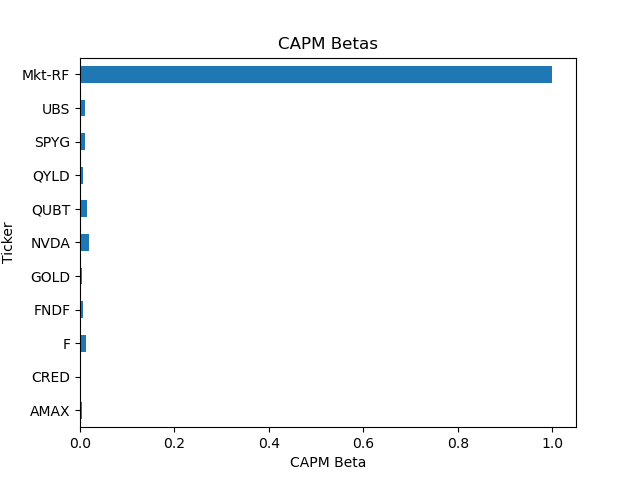

Ticker,AMAX,CRED,F,FNDF,GOLD,NVDA,QUBT,QYLD,SPYG,UBS,Mkt-RF
Ticker,,,,,,,,,,,
AMAX,0.0001,NaN,0.0001,0.0001,0.0001,0.0002,0.0002,0.0001,0.0001,0.0001,0.0062
CRED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F,0.0001,NaN,0.0008,0.0002,0.0001,0.0004,0.0004,0.0002,0.0002,0.0003,0.0204
FNDF,0.0001,NaN,0.0002,0.0002,0.0001,0.0002,0.0002,0.0001,0.0002,0.0002,0.0112
GOLD,0.0001,NaN,0.0001,0.0001,0.0005,0.0002,0.0001,0.0001,0.0001,0.0001,0.0074


In [172]:
%matplotlib widget

vcv = returns_2023s_excess.cov()
vcv['Mkt-RF'].div(vcv.loc['Mkt-RF', 'Mkt-RF']).plot(kind='barh')
plt.xlabel('CAPM Beta')
plt.title('CAPM Betas')
plt.show()
vcv.head()

In [173]:
(
    returns.mean()
    .div(returns.std())
    .mul(np.sqrt(252))
)

Ticker
AMAX   -0.4663
CRED   -0.5955
F       0.7061
FNDF    0.6866
GOLD   -0.0214
NVDA    1.1906
QUBT    0.3081
QYLD    0.5095
SPYG    0.5546
UBS     0.8218
dtype: float64

In [174]:
(
    returns_2023s_excess.mean()
    .div(returns_2023s_excess.std())
    .mul(np.sqrt(252))
)

Ticker
AMAX     -13.0151
CRED          NaN
F         -1.5135
FNDF      -4.1029
GOLD      -2.6434
NVDA      -0.8509
QUBT      -0.5655
QYLD      -4.7473
SPYG      -3.4341
UBS       -2.0618
Mkt-RF     0.5771
dtype: float64